## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [2]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [3]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you

from models import Net

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
    elif type(m)== nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)


net = Net()
net.apply(init_weights)
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout2d(p=0.1)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout2d(p=0.2)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout2d(p=0.3)
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop4): Dropout2d(p=0.4)
  (fc1): Linear(in_features=43264, out_features=1000, bias=True)
  (drop5): Dropout2d(p=0.5)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (drop6): Dropout2d(p=0.6)
  (fc3): Linear(in_features=1000, out_features=136, bias=True)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [5]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
#data_transform = transforms.Compose([Rescale(120), RandomCrop(96), Normalize(), ToTensor()])
data_transform = transforms.Compose([Rescale(240), RandomCrop(224), Normalize(), ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [6]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [7]:
# load training data in batches
batch_size = 32

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [8]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)



In [9]:
# load test data in batches
batch_size = 32

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [10]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [11]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([32, 1, 224, 224])
torch.Size([32, 68, 2])
torch.Size([32, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [12]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

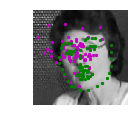

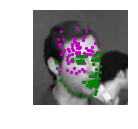

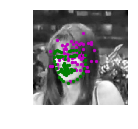

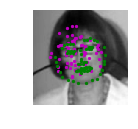

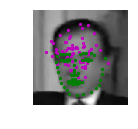

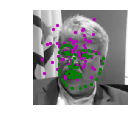

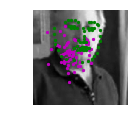

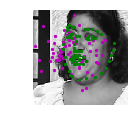

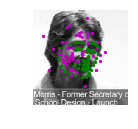

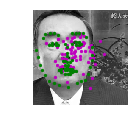

In [13]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [14]:
## TODO: Define the loss and optimization
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [15]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0

    print('Finished Training')


In [16]:
# train your network
n_epochs = 50 # start small, and increase when you've decided on your model structure and hyperparams

training_loss = train_net(n_epochs)

/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.0059356182515621185
Epoch: 1, Batch: 20, Avg. Loss: 0.0035384766161441804
Epoch: 1, Batch: 30, Avg. Loss: 0.0030822099149227142
Epoch: 1, Batch: 40, Avg. Loss: 0.0027431672066450118
Epoch: 1, Batch: 50, Avg. Loss: 0.0026584321558475493
Epoch: 1, Batch: 60, Avg. Loss: 0.0025067535638809203
Epoch: 1, Batch: 70, Avg. Loss: 0.0022931102365255354
Epoch: 1, Batch: 80, Avg. Loss: 0.0024529914408922197
Epoch: 1, Batch: 90, Avg. Loss: 0.002129636988043785
Epoch: 1, Batch: 100, Avg. Loss: 0.002066823035478592


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.0019956665337085722
Epoch: 2, Batch: 20, Avg. Loss: 0.0020619660764932633
Epoch: 2, Batch: 30, Avg. Loss: 0.002325591430068016
Epoch: 2, Batch: 40, Avg. Loss: 0.001976449653506279
Epoch: 2, Batch: 50, Avg. Loss: 0.0019298296421766282
Epoch: 2, Batch: 60, Avg. Loss: 0.001861142009496689
Epoch: 2, Batch: 70, Avg. Loss: 0.001799427941441536
Epoch: 2, Batch: 80, Avg. Loss: 0.001982919916510582
Epoch: 2, Batch: 90, Avg. Loss: 0.0019495254009962082
Epoch: 2, Batch: 100, Avg. Loss: 0.0017476600408554077


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.001799728274345398
Epoch: 3, Batch: 20, Avg. Loss: 0.0015793751329183578
Epoch: 3, Batch: 30, Avg. Loss: 0.002116220071911812
Epoch: 3, Batch: 40, Avg. Loss: 0.0016094929724931716
Epoch: 3, Batch: 50, Avg. Loss: 0.0018461463004350663
Epoch: 3, Batch: 60, Avg. Loss: 0.001731144294142723
Epoch: 3, Batch: 70, Avg. Loss: 0.0016875433474779129
Epoch: 3, Batch: 80, Avg. Loss: 0.0017322947829961778
Epoch: 3, Batch: 90, Avg. Loss: 0.0019814642667770384
Epoch: 3, Batch: 100, Avg. Loss: 0.001608306720852852


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.0018203138411045075
Epoch: 4, Batch: 20, Avg. Loss: 0.0015441102236509322
Epoch: 4, Batch: 30, Avg. Loss: 0.0016525013595819473
Epoch: 4, Batch: 40, Avg. Loss: 0.001478675790131092
Epoch: 4, Batch: 50, Avg. Loss: 0.0015799975693225861
Epoch: 4, Batch: 60, Avg. Loss: 0.0018165158927440643
Epoch: 4, Batch: 70, Avg. Loss: 0.0014671811312437057
Epoch: 4, Batch: 80, Avg. Loss: 0.0014755195900797843
Epoch: 4, Batch: 90, Avg. Loss: 0.0018298510685563088
Epoch: 4, Batch: 100, Avg. Loss: 0.0015146722793579102


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.0014729232713580132
Epoch: 5, Batch: 20, Avg. Loss: 0.001584747552871704
Epoch: 5, Batch: 30, Avg. Loss: 0.0015944167524576188
Epoch: 5, Batch: 40, Avg. Loss: 0.0017376970425248147
Epoch: 5, Batch: 50, Avg. Loss: 0.0017432939037680625
Epoch: 5, Batch: 60, Avg. Loss: 0.0014772153571248055
Epoch: 5, Batch: 70, Avg. Loss: 0.0016148757785558702
Epoch: 5, Batch: 80, Avg. Loss: 0.0013873237296938897
Epoch: 5, Batch: 90, Avg. Loss: 0.001799014002084732
Epoch: 5, Batch: 100, Avg. Loss: 0.0015926040858030318


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 10, Avg. Loss: 0.0014147076606750488
Epoch: 6, Batch: 20, Avg. Loss: 0.0014029534384608269
Epoch: 6, Batch: 30, Avg. Loss: 0.0013716080859303475
Epoch: 6, Batch: 40, Avg. Loss: 0.0017074589207768441
Epoch: 6, Batch: 50, Avg. Loss: 0.0013670662194490433
Epoch: 6, Batch: 60, Avg. Loss: 0.0013018695190548898
Epoch: 6, Batch: 70, Avg. Loss: 0.0014284623116254805
Epoch: 6, Batch: 80, Avg. Loss: 0.001600269913673401
Epoch: 6, Batch: 90, Avg. Loss: 0.0014412086382508279
Epoch: 6, Batch: 100, Avg. Loss: 0.0015408356562256814


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 10, Avg. Loss: 0.0014489565193653107
Epoch: 7, Batch: 20, Avg. Loss: 0.0014273509308695793
Epoch: 7, Batch: 30, Avg. Loss: 0.0016842424720525742
Epoch: 7, Batch: 40, Avg. Loss: 0.0014295241385698318
Epoch: 7, Batch: 50, Avg. Loss: 0.0014485496953129768
Epoch: 7, Batch: 60, Avg. Loss: 0.0016469551175832748
Epoch: 7, Batch: 70, Avg. Loss: 0.0011451318636536598
Epoch: 7, Batch: 80, Avg. Loss: 0.0015105861872434616
Epoch: 7, Batch: 90, Avg. Loss: 0.001656343936920166
Epoch: 7, Batch: 100, Avg. Loss: 0.001502438373863697


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 10, Avg. Loss: 0.0013853697776794434
Epoch: 8, Batch: 20, Avg. Loss: 0.0013523723036050796
Epoch: 8, Batch: 30, Avg. Loss: 0.001250526748597622
Epoch: 8, Batch: 40, Avg. Loss: 0.0011670896410942077
Epoch: 8, Batch: 50, Avg. Loss: 0.0011622243151068687
Epoch: 8, Batch: 60, Avg. Loss: 0.001248335175216198
Epoch: 8, Batch: 70, Avg. Loss: 0.001395789496600628
Epoch: 8, Batch: 80, Avg. Loss: 0.0012043274119496346
Epoch: 8, Batch: 90, Avg. Loss: 0.0011777741611003875
Epoch: 8, Batch: 100, Avg. Loss: 0.00140265604108572


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 10, Avg. Loss: 0.0012362028881907463
Epoch: 9, Batch: 20, Avg. Loss: 0.0012161986231803894
Epoch: 9, Batch: 30, Avg. Loss: 0.0013491032123565674
Epoch: 9, Batch: 40, Avg. Loss: 0.0011396215185523033
Epoch: 9, Batch: 50, Avg. Loss: 0.001207812525331974
Epoch: 9, Batch: 60, Avg. Loss: 0.0013111859634518624
Epoch: 9, Batch: 70, Avg. Loss: 0.0013806684017181397
Epoch: 9, Batch: 80, Avg. Loss: 0.001220225304365158
Epoch: 9, Batch: 90, Avg. Loss: 0.0016589865386486054
Epoch: 9, Batch: 100, Avg. Loss: 0.0012279973700642585


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 10, Avg. Loss: 0.0011377880200743676
Epoch: 10, Batch: 20, Avg. Loss: 0.001164138302206993
Epoch: 10, Batch: 30, Avg. Loss: 0.0012592244520783424
Epoch: 10, Batch: 40, Avg. Loss: 0.0021407203152775767
Epoch: 10, Batch: 50, Avg. Loss: 0.0010887592881917954
Epoch: 10, Batch: 60, Avg. Loss: 0.001329851932823658
Epoch: 10, Batch: 70, Avg. Loss: 0.001148814909160137
Epoch: 10, Batch: 80, Avg. Loss: 0.0015088221728801728
Epoch: 10, Batch: 90, Avg. Loss: 0.0011692065969109535
Epoch: 10, Batch: 100, Avg. Loss: 0.0010147908702492713


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 11, Batch: 10, Avg. Loss: 0.0013909763321280479
Epoch: 11, Batch: 20, Avg. Loss: 0.0012191182076931
Epoch: 11, Batch: 30, Avg. Loss: 0.0013006907552480698
Epoch: 11, Batch: 40, Avg. Loss: 0.0009361085891723633
Epoch: 11, Batch: 50, Avg. Loss: 0.0012012793198227882
Epoch: 11, Batch: 60, Avg. Loss: 0.0010758271664381028
Epoch: 11, Batch: 70, Avg. Loss: 0.0012261933758854866
Epoch: 11, Batch: 80, Avg. Loss: 0.0012524832040071488
Epoch: 11, Batch: 90, Avg. Loss: 0.0012035902440547942
Epoch: 11, Batch: 100, Avg. Loss: 0.0010665872246026992


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 12, Batch: 10, Avg. Loss: 0.0010765044987201692
Epoch: 12, Batch: 20, Avg. Loss: 0.0012015234231948853
Epoch: 12, Batch: 30, Avg. Loss: 0.0012162240073084832
Epoch: 12, Batch: 40, Avg. Loss: 0.0011355592012405396
Epoch: 12, Batch: 50, Avg. Loss: 0.0010925958901643754
Epoch: 12, Batch: 60, Avg. Loss: 0.0010802262239158152
Epoch: 12, Batch: 70, Avg. Loss: 0.0010717112720012665
Epoch: 12, Batch: 80, Avg. Loss: 0.0014017466232180596
Epoch: 12, Batch: 90, Avg. Loss: 0.001073552057147026
Epoch: 12, Batch: 100, Avg. Loss: 0.00110908642411232


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 13, Batch: 10, Avg. Loss: 0.0013130940347909927
Epoch: 13, Batch: 20, Avg. Loss: 0.0010550152882933617
Epoch: 13, Batch: 30, Avg. Loss: 0.0009491557627916336
Epoch: 13, Batch: 40, Avg. Loss: 0.0011696054562926293
Epoch: 13, Batch: 50, Avg. Loss: 0.0010455211028456688
Epoch: 13, Batch: 60, Avg. Loss: 0.0012777445390820504
Epoch: 13, Batch: 70, Avg. Loss: 0.0010525915250182152
Epoch: 13, Batch: 80, Avg. Loss: 0.0008842752724885941
Epoch: 13, Batch: 90, Avg. Loss: 0.0011156555190682412
Epoch: 13, Batch: 100, Avg. Loss: 0.0011106137558817863


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 14, Batch: 10, Avg. Loss: 0.001049265965819359
Epoch: 14, Batch: 20, Avg. Loss: 0.0010463048964738846
Epoch: 14, Batch: 30, Avg. Loss: 0.0011780422627925872
Epoch: 14, Batch: 40, Avg. Loss: 0.0010105713680386543
Epoch: 14, Batch: 50, Avg. Loss: 0.0008934843689203262
Epoch: 14, Batch: 60, Avg. Loss: 0.0009184371121227741
Epoch: 14, Batch: 70, Avg. Loss: 0.0009328841157257557
Epoch: 14, Batch: 80, Avg. Loss: 0.0011516127586364746
Epoch: 14, Batch: 90, Avg. Loss: 0.0010429232008755207
Epoch: 14, Batch: 100, Avg. Loss: 0.0010850346982479095


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 15, Batch: 10, Avg. Loss: 0.0014019092172384263
Epoch: 15, Batch: 20, Avg. Loss: 0.000903214007616043
Epoch: 15, Batch: 30, Avg. Loss: 0.0009112840928137303
Epoch: 15, Batch: 40, Avg. Loss: 0.0010888726562261581
Epoch: 15, Batch: 50, Avg. Loss: 0.0010098196640610695
Epoch: 15, Batch: 60, Avg. Loss: 0.0011026614904403687
Epoch: 15, Batch: 70, Avg. Loss: 0.0011342999562621117
Epoch: 15, Batch: 80, Avg. Loss: 0.0009971077889204024
Epoch: 15, Batch: 90, Avg. Loss: 0.001277461662888527
Epoch: 15, Batch: 100, Avg. Loss: 0.0012352810204029083


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 16, Batch: 10, Avg. Loss: 0.0009482669085264206
Epoch: 16, Batch: 20, Avg. Loss: 0.0009213888086378574
Epoch: 16, Batch: 30, Avg. Loss: 0.0008717629797756672
Epoch: 16, Batch: 40, Avg. Loss: 0.0010593153983354568
Epoch: 16, Batch: 50, Avg. Loss: 0.0008809740841388702
Epoch: 16, Batch: 60, Avg. Loss: 0.0010851707980036737
Epoch: 16, Batch: 70, Avg. Loss: 0.0011165795624256134
Epoch: 16, Batch: 80, Avg. Loss: 0.0014594760462641717
Epoch: 16, Batch: 90, Avg. Loss: 0.0009461200013756752
Epoch: 16, Batch: 100, Avg. Loss: 0.000965128242969513


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 17, Batch: 10, Avg. Loss: 0.0009243947491049767
Epoch: 17, Batch: 20, Avg. Loss: 0.0008880234360694885
Epoch: 17, Batch: 30, Avg. Loss: 0.0014452631622552871
Epoch: 17, Batch: 40, Avg. Loss: 0.0009053299278020859
Epoch: 17, Batch: 50, Avg. Loss: 0.0008495082631707192
Epoch: 17, Batch: 60, Avg. Loss: 0.0010432207286357879
Epoch: 17, Batch: 70, Avg. Loss: 0.0009819297716021538
Epoch: 17, Batch: 80, Avg. Loss: 0.0010750960521399974
Epoch: 17, Batch: 90, Avg. Loss: 0.0010303469598293305
Epoch: 17, Batch: 100, Avg. Loss: 0.0008217767998576164


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 18, Batch: 10, Avg. Loss: 0.0009891548044979573
Epoch: 18, Batch: 20, Avg. Loss: 0.0012067942880094051
Epoch: 18, Batch: 30, Avg. Loss: 0.0009922288954257966
Epoch: 18, Batch: 40, Avg. Loss: 0.0007920598611235619
Epoch: 18, Batch: 50, Avg. Loss: 0.0009071331657469272
Epoch: 18, Batch: 60, Avg. Loss: 0.0009844493009150029
Epoch: 18, Batch: 70, Avg. Loss: 0.0008790754899382591
Epoch: 18, Batch: 80, Avg. Loss: 0.0008563030809164048
Epoch: 18, Batch: 90, Avg. Loss: 0.0008009857907891274
Epoch: 18, Batch: 100, Avg. Loss: 0.0009257245138287544


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 19, Batch: 10, Avg. Loss: 0.0008357061818242074
Epoch: 19, Batch: 20, Avg. Loss: 0.0008700765520334244
Epoch: 19, Batch: 30, Avg. Loss: 0.0007483843676745892
Epoch: 19, Batch: 40, Avg. Loss: 0.001168480284512043
Epoch: 19, Batch: 50, Avg. Loss: 0.0009452156238257885
Epoch: 19, Batch: 60, Avg. Loss: 0.0009463243931531906
Epoch: 19, Batch: 70, Avg. Loss: 0.0008869916647672653
Epoch: 19, Batch: 80, Avg. Loss: 0.000921098005026579
Epoch: 19, Batch: 90, Avg. Loss: 0.0007871358953416347
Epoch: 19, Batch: 100, Avg. Loss: 0.0010364574901759625


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 20, Batch: 10, Avg. Loss: 0.0007515664920210839
Epoch: 20, Batch: 20, Avg. Loss: 0.0008729542195796967
Epoch: 20, Batch: 30, Avg. Loss: 0.0008615792170166969
Epoch: 20, Batch: 40, Avg. Loss: 0.0008992133475840092
Epoch: 20, Batch: 50, Avg. Loss: 0.0008459552712738514
Epoch: 20, Batch: 60, Avg. Loss: 0.0006928007937967777
Epoch: 20, Batch: 70, Avg. Loss: 0.0010124411508440972
Epoch: 20, Batch: 80, Avg. Loss: 0.0012576918117702008
Epoch: 20, Batch: 90, Avg. Loss: 0.0007612066380679607
Epoch: 20, Batch: 100, Avg. Loss: 0.0008356286399066449


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 21, Batch: 10, Avg. Loss: 0.0008940785042941571
Epoch: 21, Batch: 20, Avg. Loss: 0.0008985692076385021
Epoch: 21, Batch: 30, Avg. Loss: 0.00076491304859519
Epoch: 21, Batch: 40, Avg. Loss: 0.0008168449364602566
Epoch: 21, Batch: 50, Avg. Loss: 0.0006729293167591095
Epoch: 21, Batch: 60, Avg. Loss: 0.0010130116157233715
Epoch: 21, Batch: 70, Avg. Loss: 0.000821416649967432
Epoch: 21, Batch: 80, Avg. Loss: 0.0009643701240420341
Epoch: 21, Batch: 90, Avg. Loss: 0.0008088718876242638
Epoch: 21, Batch: 100, Avg. Loss: 0.0008174719288945198


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 22, Batch: 10, Avg. Loss: 0.0008151614107191563
Epoch: 22, Batch: 20, Avg. Loss: 0.0007357782162725926
Epoch: 22, Batch: 30, Avg. Loss: 0.0009013310000300408
Epoch: 22, Batch: 40, Avg. Loss: 0.0006935602389276028
Epoch: 22, Batch: 50, Avg. Loss: 0.0007990387231111526
Epoch: 22, Batch: 60, Avg. Loss: 0.0009843049608170987
Epoch: 22, Batch: 70, Avg. Loss: 0.0009079915434122086
Epoch: 22, Batch: 80, Avg. Loss: 0.000891371101140976
Epoch: 22, Batch: 90, Avg. Loss: 0.0007763601578772068
Epoch: 22, Batch: 100, Avg. Loss: 0.0007791728936135769


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 23, Batch: 10, Avg. Loss: 0.0012896066755056382
Epoch: 23, Batch: 20, Avg. Loss: 0.0007680883929133415
Epoch: 23, Batch: 30, Avg. Loss: 0.0007721636593341827
Epoch: 23, Batch: 40, Avg. Loss: 0.0007783404029905796
Epoch: 23, Batch: 50, Avg. Loss: 0.0008946614339947701
Epoch: 23, Batch: 60, Avg. Loss: 0.000985511913895607
Epoch: 23, Batch: 70, Avg. Loss: 0.000732603333890438
Epoch: 23, Batch: 80, Avg. Loss: 0.0014367093183100224
Epoch: 23, Batch: 90, Avg. Loss: 0.0009188162796199322
Epoch: 23, Batch: 100, Avg. Loss: 0.0008911966979503631


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 24, Batch: 10, Avg. Loss: 0.0009985339604318142
Epoch: 24, Batch: 20, Avg. Loss: 0.0007862482443451881
Epoch: 24, Batch: 30, Avg. Loss: 0.0007509899139404297
Epoch: 24, Batch: 40, Avg. Loss: 0.0007002384662628174
Epoch: 24, Batch: 50, Avg. Loss: 0.0007634623050689698
Epoch: 24, Batch: 60, Avg. Loss: 0.0008656008206307888
Epoch: 24, Batch: 70, Avg. Loss: 0.0007621667124330997
Epoch: 24, Batch: 80, Avg. Loss: 0.0006358350664377213
Epoch: 24, Batch: 90, Avg. Loss: 0.0006423128359019756
Epoch: 24, Batch: 100, Avg. Loss: 0.000756392627954483


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 25, Batch: 10, Avg. Loss: 0.0006664877757430077
Epoch: 25, Batch: 20, Avg. Loss: 0.0008434177413582802
Epoch: 25, Batch: 30, Avg. Loss: 0.0007257676832377911
Epoch: 25, Batch: 40, Avg. Loss: 0.0009380005560815334
Epoch: 25, Batch: 50, Avg. Loss: 0.0006930158734321594
Epoch: 25, Batch: 60, Avg. Loss: 0.0008395094200968743
Epoch: 25, Batch: 70, Avg. Loss: 0.0007428681589663028
Epoch: 25, Batch: 80, Avg. Loss: 0.0007037763260304928
Epoch: 25, Batch: 90, Avg. Loss: 0.0007079723328351974
Epoch: 25, Batch: 100, Avg. Loss: 0.0006326054632663727


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 26, Batch: 10, Avg. Loss: 0.0007221848331391812
Epoch: 26, Batch: 20, Avg. Loss: 0.0008397683314979076
Epoch: 26, Batch: 30, Avg. Loss: 0.0006894289888441563
Epoch: 26, Batch: 40, Avg. Loss: 0.0008456148244440555
Epoch: 26, Batch: 50, Avg. Loss: 0.0007181568145751953
Epoch: 26, Batch: 60, Avg. Loss: 0.0007344788312911987
Epoch: 26, Batch: 70, Avg. Loss: 0.0008327630907297135
Epoch: 26, Batch: 80, Avg. Loss: 0.0008254501968622208
Epoch: 26, Batch: 90, Avg. Loss: 0.000716911643743515
Epoch: 26, Batch: 100, Avg. Loss: 0.0007215348556637764


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 27, Batch: 10, Avg. Loss: 0.0010216850377619267
Epoch: 27, Batch: 20, Avg. Loss: 0.0007140362896025181
Epoch: 27, Batch: 30, Avg. Loss: 0.0006390621513128281
Epoch: 27, Batch: 40, Avg. Loss: 0.0006307660788297654
Epoch: 27, Batch: 50, Avg. Loss: 0.0009059707447886467
Epoch: 27, Batch: 60, Avg. Loss: 0.0008646752424538135
Epoch: 27, Batch: 70, Avg. Loss: 0.0007717908062040806
Epoch: 27, Batch: 80, Avg. Loss: 0.0006424746811389923
Epoch: 27, Batch: 90, Avg. Loss: 0.000648504838347435
Epoch: 27, Batch: 100, Avg. Loss: 0.0006308552362024784


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 28, Batch: 10, Avg. Loss: 0.0013078758083283901
Epoch: 28, Batch: 20, Avg. Loss: 0.0006806664764881134
Epoch: 28, Batch: 30, Avg. Loss: 0.00063072844222188
Epoch: 28, Batch: 40, Avg. Loss: 0.0006546326652169227
Epoch: 28, Batch: 50, Avg. Loss: 0.0006904028877615929
Epoch: 28, Batch: 60, Avg. Loss: 0.0006873946487903595
Epoch: 28, Batch: 70, Avg. Loss: 0.000656147263944149
Epoch: 28, Batch: 80, Avg. Loss: 0.0009216455444693566
Epoch: 28, Batch: 90, Avg. Loss: 0.0008031983673572541
Epoch: 28, Batch: 100, Avg. Loss: 0.0006620065793395042


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 29, Batch: 10, Avg. Loss: 0.0005918171145021915
Epoch: 29, Batch: 20, Avg. Loss: 0.0013428006172180175
Epoch: 29, Batch: 30, Avg. Loss: 0.000596348062157631
Epoch: 29, Batch: 40, Avg. Loss: 0.0006479058191180229
Epoch: 29, Batch: 50, Avg. Loss: 0.0007249905802309513
Epoch: 29, Batch: 60, Avg. Loss: 0.0006404931880533695
Epoch: 29, Batch: 70, Avg. Loss: 0.0005432806834578514
Epoch: 29, Batch: 80, Avg. Loss: 0.0009073192514479161
Epoch: 29, Batch: 90, Avg. Loss: 0.0007424025274813175
Epoch: 29, Batch: 100, Avg. Loss: 0.0008303698413074016


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 30, Batch: 10, Avg. Loss: 0.0005690640732645988
Epoch: 30, Batch: 20, Avg. Loss: 0.0006584281101822854
Epoch: 30, Batch: 30, Avg. Loss: 0.0006852433383464814
Epoch: 30, Batch: 40, Avg. Loss: 0.0006002263836562634
Epoch: 30, Batch: 50, Avg. Loss: 0.0007512754015624523
Epoch: 30, Batch: 60, Avg. Loss: 0.0008386260159313679
Epoch: 30, Batch: 70, Avg. Loss: 0.0006392381936311722
Epoch: 30, Batch: 80, Avg. Loss: 0.0005699049569666385
Epoch: 30, Batch: 90, Avg. Loss: 0.0006801002994179726
Epoch: 30, Batch: 100, Avg. Loss: 0.0006891717500984669


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 31, Batch: 10, Avg. Loss: 0.0006200091727077961
Epoch: 31, Batch: 20, Avg. Loss: 0.0006116019040346146
Epoch: 31, Batch: 30, Avg. Loss: 0.0005651209689676762
Epoch: 31, Batch: 40, Avg. Loss: 0.0006691803112626076
Epoch: 31, Batch: 50, Avg. Loss: 0.000621978610754013
Epoch: 31, Batch: 60, Avg. Loss: 0.0006168465688824653
Epoch: 31, Batch: 70, Avg. Loss: 0.0006360847130417824
Epoch: 31, Batch: 80, Avg. Loss: 0.0006729237772524357
Epoch: 31, Batch: 90, Avg. Loss: 0.0006410611681640148
Epoch: 31, Batch: 100, Avg. Loss: 0.0007108565866947174


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 32, Batch: 10, Avg. Loss: 0.0005727132745087147
Epoch: 32, Batch: 20, Avg. Loss: 0.000624584149569273
Epoch: 32, Batch: 30, Avg. Loss: 0.0007087427377700805
Epoch: 32, Batch: 40, Avg. Loss: 0.0006368433460593224
Epoch: 32, Batch: 50, Avg. Loss: 0.000701389666646719
Epoch: 32, Batch: 60, Avg. Loss: 0.0007069087624549865
Epoch: 32, Batch: 70, Avg. Loss: 0.0007572405412793159
Epoch: 32, Batch: 80, Avg. Loss: 0.0005441999062895774
Epoch: 32, Batch: 90, Avg. Loss: 0.0006166882775723935
Epoch: 32, Batch: 100, Avg. Loss: 0.0006331079378724098


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 33, Batch: 10, Avg. Loss: 0.0007198112718760967
Epoch: 33, Batch: 20, Avg. Loss: 0.0006135157272219658
Epoch: 33, Batch: 30, Avg. Loss: 0.0006725427508354187
Epoch: 33, Batch: 40, Avg. Loss: 0.0006931441947817803
Epoch: 33, Batch: 50, Avg. Loss: 0.0008141377009451389
Epoch: 33, Batch: 60, Avg. Loss: 0.0006758722700178623
Epoch: 33, Batch: 70, Avg. Loss: 0.0012411979474127293
Epoch: 33, Batch: 80, Avg. Loss: 0.0005955567359924316
Epoch: 33, Batch: 90, Avg. Loss: 0.0006080984026193618
Epoch: 33, Batch: 100, Avg. Loss: 0.0006126826107501984


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 34, Batch: 10, Avg. Loss: 0.0007600164860486984
Epoch: 34, Batch: 20, Avg. Loss: 0.000740480199456215
Epoch: 34, Batch: 30, Avg. Loss: 0.0005636830031871795
Epoch: 34, Batch: 40, Avg. Loss: 0.0009254818186163902
Epoch: 34, Batch: 50, Avg. Loss: 0.000747196551412344
Epoch: 34, Batch: 60, Avg. Loss: 0.00068016891553998
Epoch: 34, Batch: 70, Avg. Loss: 0.0006597112044692039
Epoch: 34, Batch: 80, Avg. Loss: 0.000576071284711361
Epoch: 34, Batch: 90, Avg. Loss: 0.0005950611419975757
Epoch: 34, Batch: 100, Avg. Loss: 0.0005644150525331497


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 35, Batch: 10, Avg. Loss: 0.0006018893681466579
Epoch: 35, Batch: 20, Avg. Loss: 0.0005679695345461368
Epoch: 35, Batch: 30, Avg. Loss: 0.0012877961359918117
Epoch: 35, Batch: 40, Avg. Loss: 0.0006517251208424568
Epoch: 35, Batch: 50, Avg. Loss: 0.0007148748487234115
Epoch: 35, Batch: 60, Avg. Loss: 0.0006280378215014935
Epoch: 35, Batch: 70, Avg. Loss: 0.0007724611014127731
Epoch: 35, Batch: 80, Avg. Loss: 0.0006329701952636242
Epoch: 35, Batch: 90, Avg. Loss: 0.0005824876576662063
Epoch: 35, Batch: 100, Avg. Loss: 0.0006123628169298172


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 36, Batch: 10, Avg. Loss: 0.0006644423007965088
Epoch: 36, Batch: 20, Avg. Loss: 0.0009870130121707916
Epoch: 36, Batch: 30, Avg. Loss: 0.0004673714116215706
Epoch: 36, Batch: 40, Avg. Loss: 0.0005432094633579254
Epoch: 36, Batch: 50, Avg. Loss: 0.0007092512100934982
Epoch: 36, Batch: 60, Avg. Loss: 0.0006067070551216602
Epoch: 36, Batch: 70, Avg. Loss: 0.0006573592871427536
Epoch: 36, Batch: 80, Avg. Loss: 0.0009509057067334652
Epoch: 36, Batch: 90, Avg. Loss: 0.0008484961949288845
Epoch: 36, Batch: 100, Avg. Loss: 0.0005264734737575054


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 37, Batch: 10, Avg. Loss: 0.0005910093523561954
Epoch: 37, Batch: 20, Avg. Loss: 0.0005614714585244656
Epoch: 37, Batch: 30, Avg. Loss: 0.0005350201725959777
Epoch: 37, Batch: 40, Avg. Loss: 0.0005573734752833844
Epoch: 37, Batch: 50, Avg. Loss: 0.0006301902607083321
Epoch: 37, Batch: 60, Avg. Loss: 0.0006555147171020508
Epoch: 37, Batch: 70, Avg. Loss: 0.0007322663366794586
Epoch: 37, Batch: 80, Avg. Loss: 0.0005725336186587811
Epoch: 37, Batch: 90, Avg. Loss: 0.0007019441239535808
Epoch: 37, Batch: 100, Avg. Loss: 0.0009636678248643875


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 38, Batch: 10, Avg. Loss: 0.0005692536868155002
Epoch: 38, Batch: 20, Avg. Loss: 0.0006341686472296715
Epoch: 38, Batch: 30, Avg. Loss: 0.0006444408744573593
Epoch: 38, Batch: 40, Avg. Loss: 0.0006062841899693013
Epoch: 38, Batch: 50, Avg. Loss: 0.000607106652110815
Epoch: 38, Batch: 60, Avg. Loss: 0.0006653398759663105
Epoch: 38, Batch: 70, Avg. Loss: 0.0006909799203276635
Epoch: 38, Batch: 80, Avg. Loss: 0.0005875909887254238
Epoch: 38, Batch: 90, Avg. Loss: 0.0007204718589782715
Epoch: 38, Batch: 100, Avg. Loss: 0.0006178390122950077


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 39, Batch: 10, Avg. Loss: 0.0005170323699712754
Epoch: 39, Batch: 20, Avg. Loss: 0.000580714974552393
Epoch: 39, Batch: 30, Avg. Loss: 0.0006209126152098179
Epoch: 39, Batch: 40, Avg. Loss: 0.0005116526447236538
Epoch: 39, Batch: 50, Avg. Loss: 0.0005476849898695946
Epoch: 39, Batch: 60, Avg. Loss: 0.0006119078733026981
Epoch: 39, Batch: 70, Avg. Loss: 0.0005336161442101001
Epoch: 39, Batch: 80, Avg. Loss: 0.0005673796646296978
Epoch: 39, Batch: 90, Avg. Loss: 0.0012451019324362278
Epoch: 39, Batch: 100, Avg. Loss: 0.0005321716889739037


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 40, Batch: 10, Avg. Loss: 0.000697444211691618
Epoch: 40, Batch: 20, Avg. Loss: 0.0005245243012905121
Epoch: 40, Batch: 30, Avg. Loss: 0.000540490236133337
Epoch: 40, Batch: 40, Avg. Loss: 0.000525655709207058
Epoch: 40, Batch: 50, Avg. Loss: 0.0006700833961367607
Epoch: 40, Batch: 60, Avg. Loss: 0.0006200649738311768
Epoch: 40, Batch: 70, Avg. Loss: 0.0005503908209502697
Epoch: 40, Batch: 80, Avg. Loss: 0.000549151461571455
Epoch: 40, Batch: 90, Avg. Loss: 0.00048603620380163195
Epoch: 40, Batch: 100, Avg. Loss: 0.00057220727391541


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 41, Batch: 10, Avg. Loss: 0.0007881904132664204
Epoch: 41, Batch: 20, Avg. Loss: 0.0005110821425914764
Epoch: 41, Batch: 30, Avg. Loss: 0.0006818544194102287
Epoch: 41, Batch: 40, Avg. Loss: 0.00048644911497831345
Epoch: 41, Batch: 50, Avg. Loss: 0.001063101213425398
Epoch: 41, Batch: 60, Avg. Loss: 0.0005862582400441169
Epoch: 41, Batch: 70, Avg. Loss: 0.0006394283771514892
Epoch: 41, Batch: 80, Avg. Loss: 0.0005015740282833576
Epoch: 41, Batch: 90, Avg. Loss: 0.0005820883363485336
Epoch: 41, Batch: 100, Avg. Loss: 0.000547200083732605


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 42, Batch: 10, Avg. Loss: 0.0005997329391539097
Epoch: 42, Batch: 20, Avg. Loss: 0.00046140993013978006
Epoch: 42, Batch: 30, Avg. Loss: 0.0004472593851387501
Epoch: 42, Batch: 40, Avg. Loss: 0.0009524671733379364
Epoch: 42, Batch: 50, Avg. Loss: 0.0005599525161087513
Epoch: 42, Batch: 60, Avg. Loss: 0.0007745783515274525
Epoch: 42, Batch: 70, Avg. Loss: 0.0005156474597752094
Epoch: 42, Batch: 80, Avg. Loss: 0.0007140094377100467
Epoch: 42, Batch: 90, Avg. Loss: 0.0005550427399575711
Epoch: 42, Batch: 100, Avg. Loss: 0.0004945005886256695


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 43, Batch: 10, Avg. Loss: 0.000465627983212471
Epoch: 43, Batch: 20, Avg. Loss: 0.000548555439338088
Epoch: 43, Batch: 30, Avg. Loss: 0.0004724307954311371
Epoch: 43, Batch: 40, Avg. Loss: 0.0005493397116661072
Epoch: 43, Batch: 50, Avg. Loss: 0.0005962502248585224
Epoch: 43, Batch: 60, Avg. Loss: 0.0006709547340869904
Epoch: 43, Batch: 70, Avg. Loss: 0.0006556617245078087
Epoch: 43, Batch: 80, Avg. Loss: 0.0007788360081613064
Epoch: 43, Batch: 90, Avg. Loss: 0.0006467311978340149
Epoch: 43, Batch: 100, Avg. Loss: 0.0007528816126286984


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 44, Batch: 10, Avg. Loss: 0.0010210729986429214
Epoch: 44, Batch: 20, Avg. Loss: 0.0005357900001108646
Epoch: 44, Batch: 30, Avg. Loss: 0.0005376752018928527
Epoch: 44, Batch: 40, Avg. Loss: 0.00046988148242235186
Epoch: 44, Batch: 50, Avg. Loss: 0.0006595685444772244
Epoch: 44, Batch: 60, Avg. Loss: 0.0005899384133517742
Epoch: 44, Batch: 70, Avg. Loss: 0.0005110606662929059
Epoch: 44, Batch: 80, Avg. Loss: 0.00047348388284444807
Epoch: 44, Batch: 90, Avg. Loss: 0.0005397966019809246
Epoch: 44, Batch: 100, Avg. Loss: 0.000467346953228116


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 45, Batch: 10, Avg. Loss: 0.0006396057084202767
Epoch: 45, Batch: 20, Avg. Loss: 0.0005567678026854992
Epoch: 45, Batch: 30, Avg. Loss: 0.00062851757183671
Epoch: 45, Batch: 40, Avg. Loss: 0.0006852409578859807
Epoch: 45, Batch: 50, Avg. Loss: 0.0005046113133430481
Epoch: 45, Batch: 60, Avg. Loss: 0.0004902693592011929
Epoch: 45, Batch: 70, Avg. Loss: 0.000568958044052124
Epoch: 45, Batch: 80, Avg. Loss: 0.0005813291594386101
Epoch: 45, Batch: 90, Avg. Loss: 0.0006481939628720283
Epoch: 45, Batch: 100, Avg. Loss: 0.0005260254517197609


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 46, Batch: 10, Avg. Loss: 0.00048366690054535866
Epoch: 46, Batch: 20, Avg. Loss: 0.0009008980430662632
Epoch: 46, Batch: 30, Avg. Loss: 0.0004528682269155979
Epoch: 46, Batch: 40, Avg. Loss: 0.0004948940500617027
Epoch: 46, Batch: 50, Avg. Loss: 0.0005022743418812752
Epoch: 46, Batch: 60, Avg. Loss: 0.0005716545395553112
Epoch: 46, Batch: 70, Avg. Loss: 0.0007274032905697823
Epoch: 46, Batch: 80, Avg. Loss: 0.0006733576916158199
Epoch: 46, Batch: 90, Avg. Loss: 0.0007477794475853443
Epoch: 46, Batch: 100, Avg. Loss: 0.0005386066474020482


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 47, Batch: 10, Avg. Loss: 0.0004871651381254196
Epoch: 47, Batch: 20, Avg. Loss: 0.00045981039106845854
Epoch: 47, Batch: 30, Avg. Loss: 0.0008235893473029136
Epoch: 47, Batch: 40, Avg. Loss: 0.0004942245278507471
Epoch: 47, Batch: 50, Avg. Loss: 0.0007460761740803719
Epoch: 47, Batch: 60, Avg. Loss: 0.0006002965979278088
Epoch: 47, Batch: 70, Avg. Loss: 0.0004843447059392929
Epoch: 47, Batch: 80, Avg. Loss: 0.0008388829976320267
Epoch: 47, Batch: 90, Avg. Loss: 0.0004652776308357716
Epoch: 47, Batch: 100, Avg. Loss: 0.000502953190356493


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 48, Batch: 10, Avg. Loss: 0.0005741898305714131
Epoch: 48, Batch: 20, Avg. Loss: 0.00046093795076012614
Epoch: 48, Batch: 30, Avg. Loss: 0.0004935004021972418
Epoch: 48, Batch: 40, Avg. Loss: 0.0005629475750029087
Epoch: 48, Batch: 50, Avg. Loss: 0.0006893058083951473
Epoch: 48, Batch: 60, Avg. Loss: 0.0006829846389591694
Epoch: 48, Batch: 70, Avg. Loss: 0.0005125396139919758
Epoch: 48, Batch: 80, Avg. Loss: 0.00047909069806337354
Epoch: 48, Batch: 90, Avg. Loss: 0.0006750067099928856
Epoch: 48, Batch: 100, Avg. Loss: 0.001067030355334282


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 49, Batch: 10, Avg. Loss: 0.0004451696984469891
Epoch: 49, Batch: 20, Avg. Loss: 0.0006825744099915028
Epoch: 49, Batch: 30, Avg. Loss: 0.0004918193854391575
Epoch: 49, Batch: 40, Avg. Loss: 0.0004895343463867903
Epoch: 49, Batch: 50, Avg. Loss: 0.0005451088659465313
Epoch: 49, Batch: 60, Avg. Loss: 0.00046880040317773817
Epoch: 49, Batch: 70, Avg. Loss: 0.0005331493988633155
Epoch: 49, Batch: 80, Avg. Loss: 0.0005158284343779087
Epoch: 49, Batch: 90, Avg. Loss: 0.00046178322285413744
Epoch: 49, Batch: 100, Avg. Loss: 0.0006496756747364998


/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 50, Batch: 10, Avg. Loss: 0.0012923195771872998
Epoch: 50, Batch: 20, Avg. Loss: 0.000602512776851654
Epoch: 50, Batch: 30, Avg. Loss: 0.0004986586980521678
Epoch: 50, Batch: 40, Avg. Loss: 0.000515994094312191
Epoch: 50, Batch: 50, Avg. Loss: 0.001228139866143465
Epoch: 50, Batch: 60, Avg. Loss: 0.0005483755134046078
Epoch: 50, Batch: 70, Avg. Loss: 0.0005889109522104263
Epoch: 50, Batch: 80, Avg. Loss: 0.0004784164652228355
Epoch: 50, Batch: 90, Avg. Loss: 0.0005203877184540033
Epoch: 50, Batch: 100, Avg. Loss: 0.00044925644993782044
Finished Training


## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [18]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/pamela/udacity_CVND/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([32, 1, 224, 224])
torch.Size([32, 68, 2])
torch.Size([32, 68, 2])


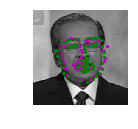

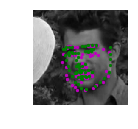

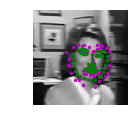

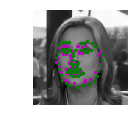

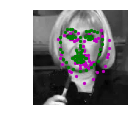

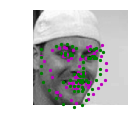

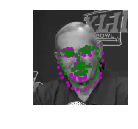

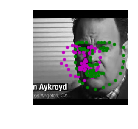

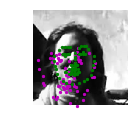

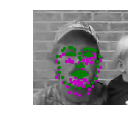

In [19]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

In [20]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_1_new.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: I considered both stochastic gradient descent and adam optimizer. I had read that adam optimizer combines AdaGrad and RMSProp, so I was keen to see if it performed better. I tried both and found Adam optimizer indeed worked better in this scenario.

As this is a regression problem, I used Mean Squared Error which is considered to be a reasonable choice. I used nn.MSELoss() for the Loss function.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: I referred NAIMISHNET for the network architecture. I have defined 4 convolutional layers and 3 fully connected layers. I am using dropout in each of these layers with increasing probability as mentioned in the paper and ELU as activation function.

I started working with image size 224x224, in Udacity workspace but found some processing errors that seemed like envirnoment issues. I then switched to 96x96 (clue from NAMISHNET) and found it be working well.

I have run 224x224 version of my notebook from my own computer and I am submitting both versions.

For the conv layer weight initialization, I am using a normal distribution and for the fully connected layers, I am using xavier_uniform distribution. Filter map sizes for both of these are 32, 64, 128, 256.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: I started with a smaller batch size 10, and then moved up a bit finally settling with 32. I didn't want the batch size to be too big, as it might degrade the model's performance.

I have used 50 epochs. I initially started training with 10 epochs and gradually increased it to 50. I didn't want to use too many epochs, to avoid overfitting. Though I am using dropouts, I am not using any batch norm, so I thought it would be nice to keep epoch size to a moderate value.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[ 0.08966833 -0.01318847 -0.05988565  0.06463196 -0.04235184]
 [ 0.06852148  0.06844945 -0.06504162 -0.00646655  0.00106295]
 [-0.06196728 -0.0023732  -0.00315547  0.04304379 -0.00697931]
 [ 0.10279494 -0.01540118  0.04009727 -0.04868008  0.02035319]
 [ 0.04700668 -0.03017765 -0.041961    0.00122799 -0.06394692]]
(5, 5)


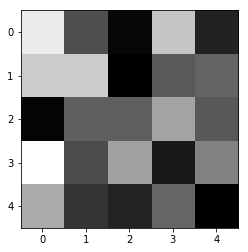

In [26]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

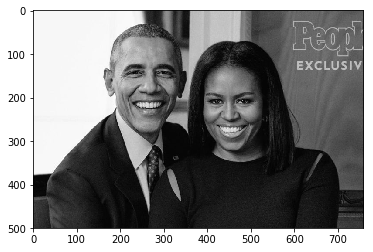

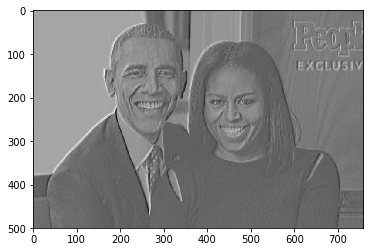

In [27]:
##TODO: load in and display any image from the transformed test dataset

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image

import cv2

#print(w.shape)
image = cv2.imread('images/obamas.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.imshow(image, cmap='gray')
plt.show()

dst = cv2.filter2D(image, 3, w[0][0])
plt.imshow(dst, cmap='gray')
plt.show()


### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**:  I think the filter I have chosen is detecting the edges, like the edges of their hair, facial features and clothes.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!